# Predicting Bike Sharing Demand

In [398]:
from statistics import linear_regression

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import mlflow
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import root_mean_squared_log_error, make_scorer


# from matplotlib.pyplot import ylabel
# from prompt_toolkit.shortcuts import set_title

# Data Exploration<br>

## Import Data

In [399]:
df_hour = pd.read_csv('bike+sharing+dataset/hour.csv')
# df_day = pd.read_csv('bike+sharing+dataset/day.csv')


## Overview of the Data

In [400]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Look for missing Data / compare entries with Non-Null Count

In [401]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


## convert dteday to datetime

In [402]:
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])

## Statistics

In [403]:
df_hour.describe(include='number').style.background_gradient(cmap='Pastel1')

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.000000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.029500,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.500000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.000000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.500000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Time-based analysis

Text(0.5, 1.0, 'Registered vs Casual')

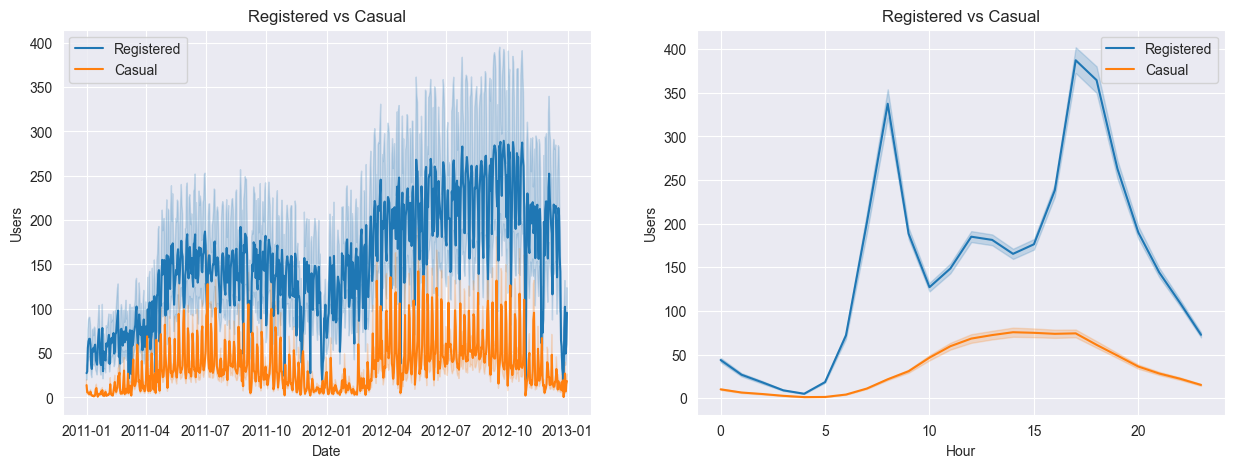

In [404]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))
# plt.figure(figsize=(8, 5))
sns.lineplot(data=df_hour, x='dteday', y='registered', label='Registered', ax=ax0)
sns.lineplot(data=df_hour, x='dteday', y='casual', label='Casual', ax=ax0)

ax0.set_xlabel('Date')
ax0.set_ylabel('Users')

ax0.set_title('Registered vs Casual')

sns.lineplot(data=df_hour, x='hr', y='registered', label='Registered', ax=ax1)
sns.lineplot(data=df_hour, x='hr', y='casual', label='Casual', ax=ax1)

ax1.set_xlabel('Hour')
ax1.set_ylabel('Users')
ax1.set_title('Registered vs Casual')


More registered users than casual users. The number of registered useres is raising more over 1 year than of the casual users

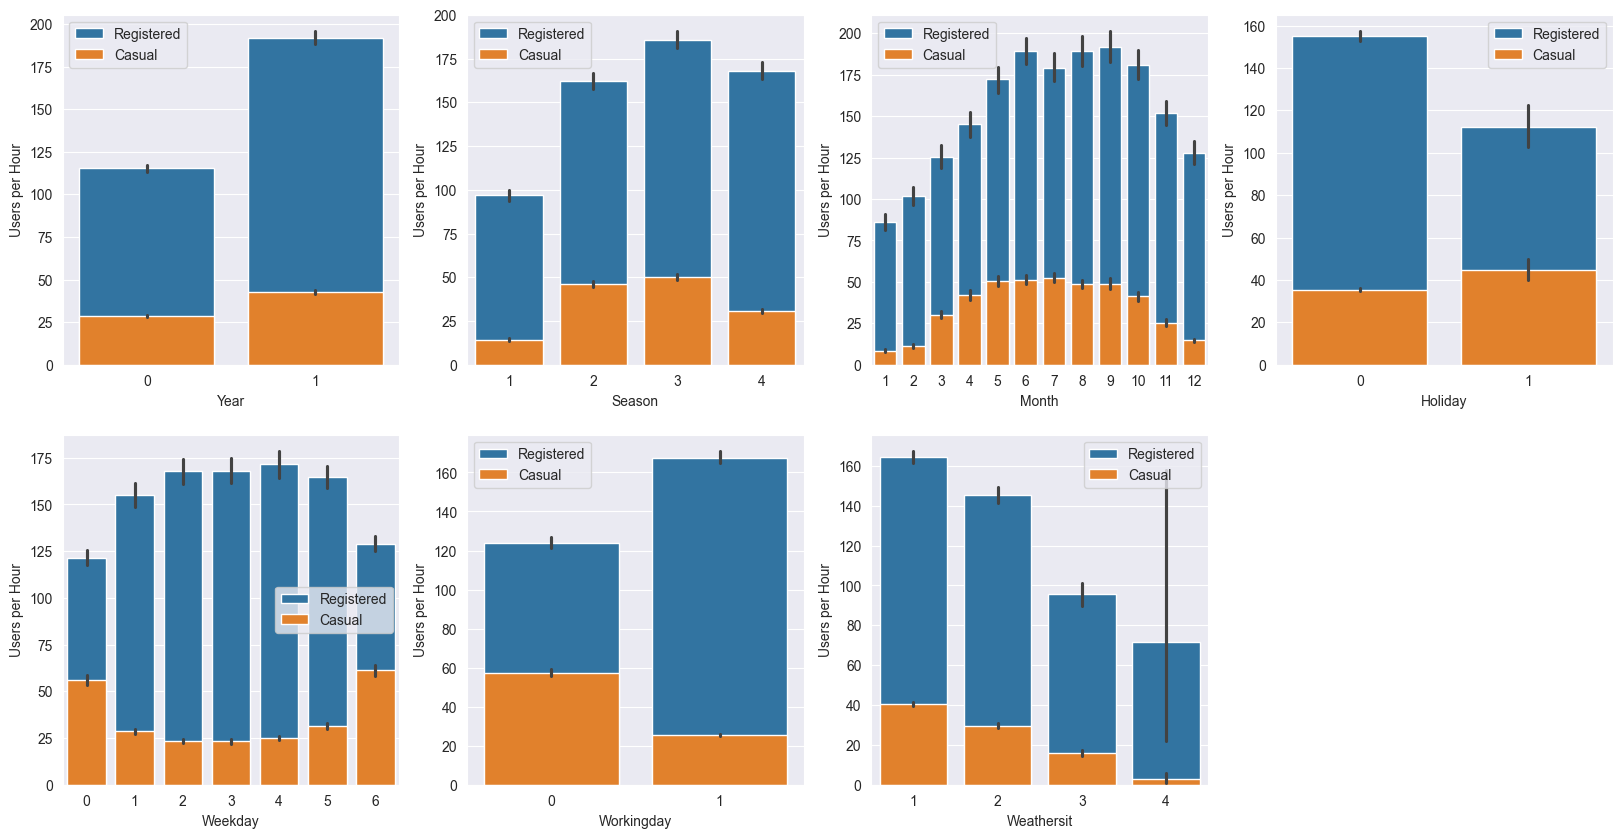

In [405]:
time_list = ['yr', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

name_list = ['Year', 'Season', 'Month', 'Holiday', 'Weekday', 'Workingday', 'Weathersit']

fig, axes = plt.subplots(2, 4, figsize=(20,10))
axes = axes.flatten()
for i, col in enumerate(time_list):
    sns.barplot(data=df_hour, x=col, y='registered', ax=axes[i], label='Registered')
    sns.barplot(data=df_hour, x=col, y='casual', ax=axes[i], label='Casual')
    axes[i].set_xlabel(name_list[i])
    axes[i].set_ylabel('Users per Hour')

axes[7].set_visible(False)


Year: Bigger growth in registered users.<br>
Season: Season 3 is the strongest. Season 1 the weakest.<br>
Month: first month is the weakest. Ninth month the strongest.<br>
Holiday: fewer registered users on holidays but more casual users. Still less in general.<br>
Weekday: Day0 has the fewest users.<br>
Workingday: On working days the majority of users are registered. On non-working days its 50/50.<br>
Weathersit: most users Weathersit: 1.

## Distribution of Temperature / Correlation with users

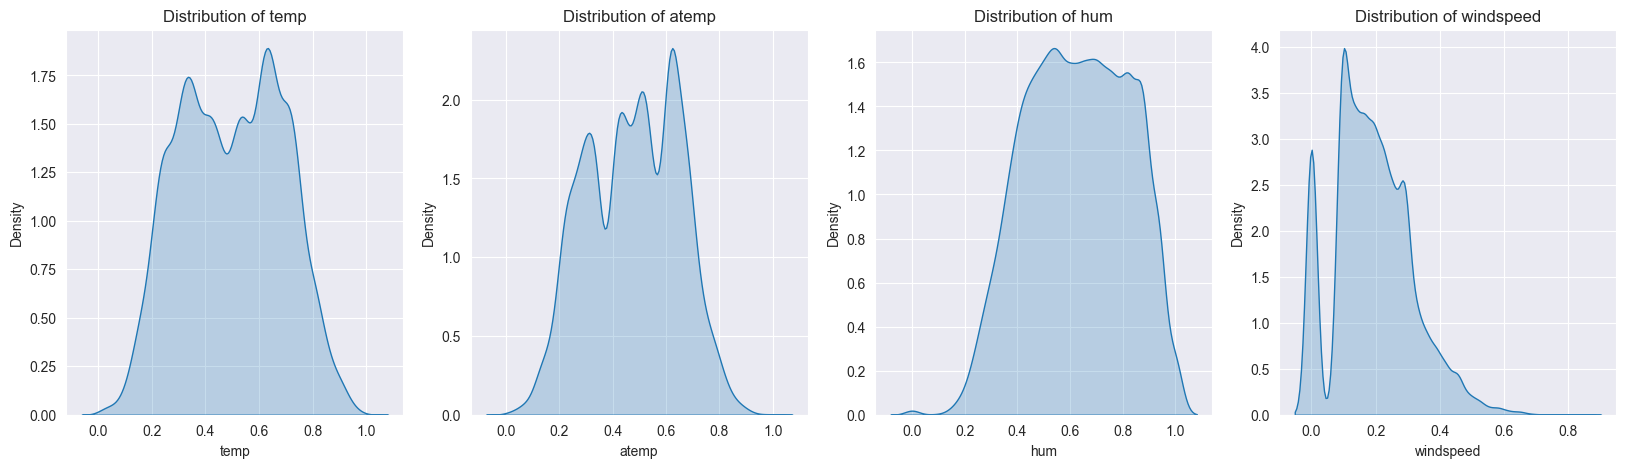

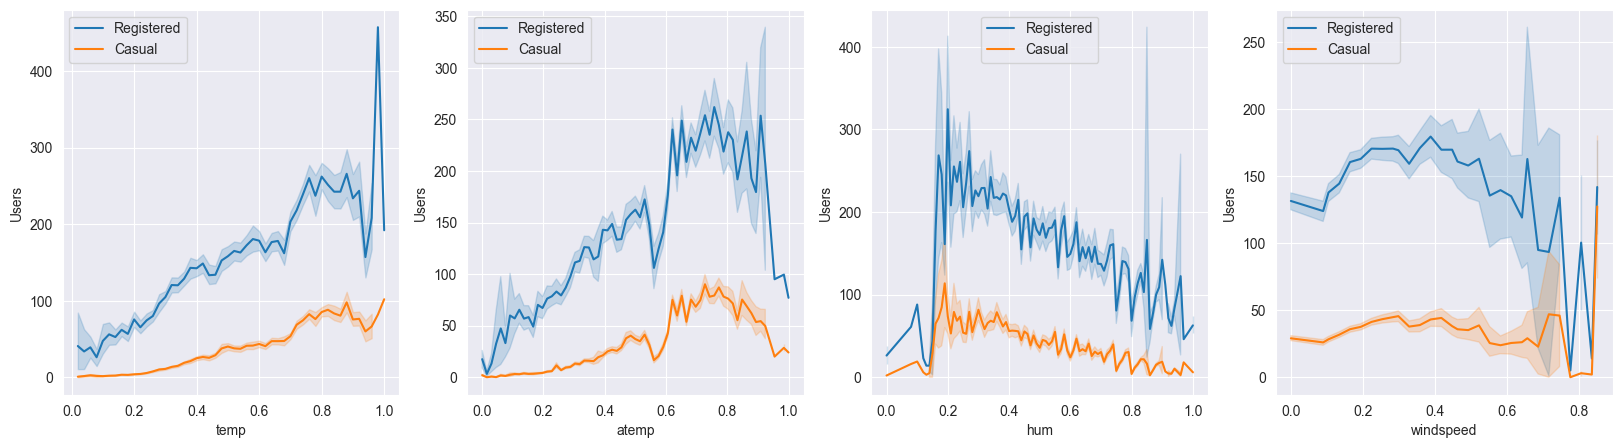

In [406]:
lst_values = ['temp', 'atemp', 'hum', 'windspeed']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for i, col in enumerate(lst_values):
    sns.kdeplot(data=df_hour[col], fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.show()
lst_values = ['temp', 'atemp', 'hum', 'windspeed']
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

for i, value in enumerate(lst_values):
    sns.lineplot(data=df_hour, x=value, y='registered', ax=axes[i], label='Registered')
    sns.lineplot(data=df_hour, x=value, y='casual', ax=axes[i], label='Casual')
    axes[i].set_ylabel('Users')

There is no significant correlation

## Correlation

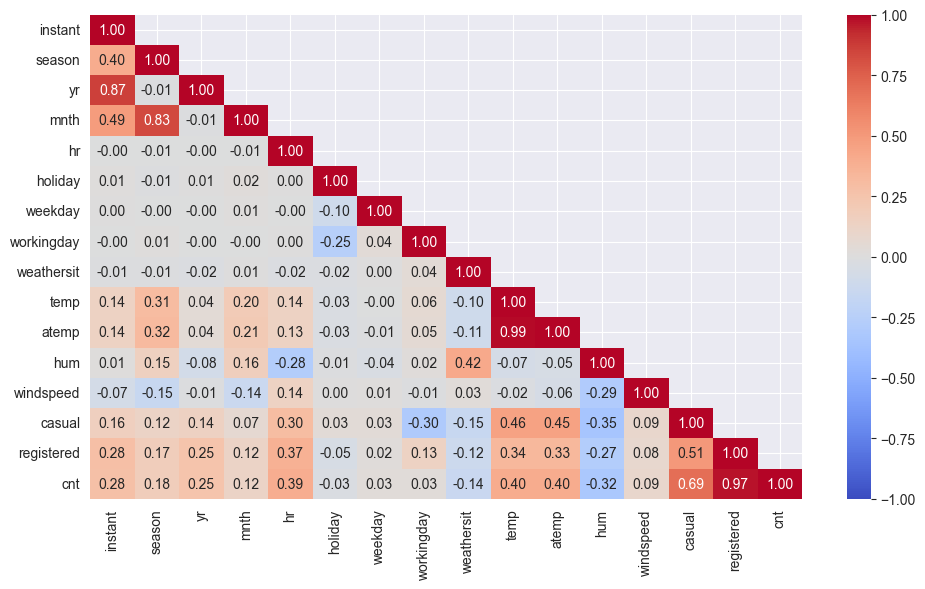

In [407]:
numeric_df = df_hour.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask, center=0, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm')
plt.tight_layout()

## Clean Data

In [408]:
df_hour = df_hour.drop(columns=['instant', 'atemp', 'dteday', 'registered', 'casual'])
df_hour['weathersit'] = df_hour['weathersit'].replace({1: 'clear', 2: 'mist', 3: 'light snow', 4: 'heavy rain'})

df_encoded = pd.get_dummies(df_hour, columns=['season', 'mnth', 'weekday', 'weathersit'], dtype=int)

df_encoded.sample()

,yr,hr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_clear,weathersit_heavy rain,weathersit_light snow,weathersit_mist
2451,0,1,0,0,0.42,0.67,0.2239,31,0,1,...,0,0,0,0,0,0,1,0,0,0


In [409]:
df_encoded.sample()


,yr,hr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_clear,weathersit_heavy rain,weathersit_light snow,weathersit_mist
10470,1,9,0,0,0.44,0.88,0.0896,321,1,0,...,0,0,0,0,0,1,0,0,0,1


In [410]:
df_hour

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,clear,0.24,0.81,0.0000,16
1,1,0,1,1,0,6,0,clear,0.22,0.80,0.0000,40
2,1,0,1,2,0,6,0,clear,0.22,0.80,0.0000,32
3,1,0,1,3,0,6,0,clear,0.24,0.75,0.0000,13
4,1,0,1,4,0,6,0,clear,0.24,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,mist,0.26,0.60,0.1642,119
17375,1,1,12,20,0,1,1,mist,0.26,0.60,0.1642,89
17376,1,1,12,21,0,1,1,clear,0.26,0.60,0.1642,90
17377,1,1,12,22,0,1,1,clear,0.26,0.56,0.1343,61


In [411]:
target = 'cnt'
feature_hour = df_encoded.columns.drop(target)

X = df_encoded[feature_hour]
y = df_encoded[target]

In [412]:
X.head()

,yr,hr,holiday,workingday,temp,hum,windspeed,season_1,season_2,season_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_clear,weathersit_heavy rain,weathersit_light snow,weathersit_mist
0,0,0,0,0,0.24,0.81,0.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,0,1,0,0,0.22,0.80,0.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,2,0,0,0.22,0.80,0.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
3,0,3,0,0,0.24,0.75,0.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4,0,4,0,0,0.24,0.75,0.0,1,0,0,...,0,0,0,0,0,1,1,0,0,0


In [413]:
X_test.head()

,yr,hr,holiday,workingday,temp,hum,windspeed,season_1,season_2,season_3,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_clear,weathersit_heavy rain,weathersit_light snow,weathersit_mist
9731,1,10,0,1,0.34,0.57,0.2985,1,0,0,...,0,0,1,0,0,0,1,0,0,0
9532,1,3,0,1,0.30,0.70,0.0000,1,0,0,...,0,1,0,0,0,0,0,0,0,1
8748,1,8,0,1,0.20,0.75,0.0000,1,0,0,...,0,0,0,1,0,0,0,0,0,1
16464,1,18,0,1,0.46,0.44,0.0000,0,0,0,...,0,0,0,0,1,0,0,0,0,1
14157,1,2,0,0,0.62,0.88,0.1642,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [414]:
y.head()

0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64

## Create features and target variable

In [415]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


## Train model

In [416]:

# Define models and parameter grids
models = {
    'Linear Regression': (
        Pipeline([
            ('scaler', StandardScaler()),
            ('variance_filter', VarianceThreshold(threshold=0.01)),
            ('model', LinearRegression())
        ]),
         {}),

    'Random Forest': (Pipeline([('scaler', StandardScaler()),
                                ('variance_filter', VarianceThreshold(threshold=0.01)),
                               ('model', RandomForestRegressor())]),
                     {'model__n_estimators': [100, 200],
                      'model__max_depth': [None, 5, 10]}),

    'XGBoost': (Pipeline([('scaler', StandardScaler()),
                          ('variance_filter', VarianceThreshold(threshold=0.01)),
                         ('model', XGBRegressor())]),
               {'model__n_estimators': [100, 200],
                'model__learning_rate': [0.01, 0.1]})
}

mlflow.set_tracking_uri('http://localhost:5000')
experiment_name = "Bike Sharing Models"
mlflow.set_experiment(experiment_name)
mlflow.sklearn.autolog(disable=True)

In [417]:
X_train.shape

(12165, 34)

In [418]:
X_test.shape

(2607, 34)

In [419]:
def safe_rmsle(y_true, y_pred):
    min_true = min(y_true)
    min_pred = min(y_pred)

    # Calculate offset (add 1 to ensure strictly positive values)
    offset = abs(min(min_true, min_pred, 0)) + 1

    # Apply offset to both arrays
    y_true_pos = y_true + offset
    y_pred_pos = y_pred + offset

    return root_mean_squared_log_error(y_true_pos, y_pred_pos)


In [420]:

for model_name, (pipeline, params) in models.items():
    with mlflow.start_run(run_name=model_name, nested=True):
        # GridSearchCV for models with parameters
        if params:
            # rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)
            grid_search = GridSearchCV(
                pipeline,
                params,
                cv=3,
                scoring='neg_mean_squared_error',
                # scoring=rmsle_scorer,
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
        else:
            # For Linear Regression without grid search
            best_model = pipeline.fit(X_train, y_train)

        # Validation metrics
        y_pred = best_model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        rmsle = safe_rmsle(y_val, y_pred)
        # rmsle = root_mean_squared_log_error(y_val, y_pred)

        # MLflow logging
        mlflow.log_params(params)
        mlflow.log_metrics({
            'val_mse': mse,
            'val_rmsle': rmsle,
            'val_r2': r2
        })

        # Log model with signature
        signature = mlflow.models.infer_signature(X_val, y_pred)
        if "XGB" in model_name:
            mlflow.xgboost.log_model(
                best_model.named_steps['model'],
                artifact_path=model_name,
                signature=signature,
                conda_env=None
            )
        else:
            mlflow.sklearn.log_model(
                best_model,
                artifact_path=model_name,
                signature=signature,
                conda_env=None
            )

        print(f"{model_name} - RMSLE: {rmsle:.2f} MSE: {mse:.2f}, R2: {r2:.2f}")




/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model sche

Linear Regression - RMSLE: 0.41 MSE: 18400.65, R2: 0.40
🏃 View run Linear Regression at: http://localhost:5000/#/experiments/703001840332528874/runs/f2e8ee43b0b7444ab9595b958fae5ca9
🧪 View experiment at: http://localhost:5000/#/experiments/703001840332528874


/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/05/09 14:13:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Random Forest - RMSLE: 0.33 MSE: 1690.56, R2: 0.95
🏃 View run Random Forest at: http://localhost:5000/#/experiments/703001840332528874/runs/e47121b5a84944a7b90c22b235047848
🧪 View experiment at: http://localhost:5000/#/experiments/703001840332528874


/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/level3/Documents/level3/part1/.venv/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [14:13:36] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON

XGBoost - RMSLE: 0.24 MSE: 1617.35, R2: 0.95
🏃 View run XGBoost at: http://localhost:5000/#/experiments/703001840332528874/runs/4d1cb40992ef40578b9d08a25aab1e93
🧪 View experiment at: http://localhost:5000/#/experiments/703001840332528874


In [421]:
import mlflow
from mlflow.entities import ViewType

# Set your tracking URI
mlflow.set_tracking_uri('http://localhost:5000')
try:
    mlflow.end_run()  # Clean up any existing runs
except:
    pass  # Ignore any errors if no runs are active

with mlflow.start_run(run_name='Final Evaluation'):
    # Get the experiment by name
    experiment = mlflow.get_experiment_by_name("Bike Sharing Models")

    # Search for runs and order by val_mse
    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        run_view_type=ViewType.ACTIVE_ONLY,
        # order_by=["metrics.val_mse"],  # Sort by val_mse ascending (smallest first)
        order_by=["metrics.val_rmsle"],  # Sort by val_rmsle ascending (smallest first)
        max_results=1  # Get only the best run
    )
    if not runs.empty:
        best_run_id = runs.iloc[0].run_id
        best_run = mlflow.get_run(best_run_id)
        # best_val_mse = runs.iloc[0]['metrics.val_mse']
        best_val_rmsle = runs.iloc[0]['metrics.val_rmsle']
        model_name = best_run.data.tags['mlflow.runName']

        print(f"Best model found: {model_name}")
        print(f"Run ID: {best_run_id}")
        # print(f"Validation MSE: {best_val_mse:.4f}")
        print(f"Validation RMSLE: {best_val_mse:.4f}")

        # Load the best model based on its type
        if "XGBoost" in model_name:
            best_model = mlflow.xgboost.load_model(f"runs:/{best_run_id}/{model_name}")
        else:
            best_model = mlflow.sklearn.load_model(f"runs:/{best_run_id}/{model_name}")
        test_pred = best_model.predict(X_test)
        mlflow.log_metrics({
        'test_mse': mean_squared_error(y_test, test_pred),
        'test_rmsle': root_mean_squared_log_error(y_test, test_pred),
        'test_r2': r2_score(y_test, test_pred)
        })

        mlflow.end_run()
    else:
        print("No runs found")

Best model found: XGBoost
Run ID: 4d1cb40992ef40578b9d08a25aab1e93
Validation RMSLE: 1617.3529
🏃 View run Final Evaluation at: http://localhost:5000/#/experiments/703001840332528874/runs/02973fad0b574796921d8121e5dbed7d
🧪 View experiment at: http://localhost:5000/#/experiments/703001840332528874
